<a href="https://colab.research.google.com/github/mordor-ai/M2-MIASHS-DIVERS/blob/main/BTC_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Tomorrow’s Bitcoin (BTC) Price with Recurrent Neural Networks
## Using Recurrent Neural Networks to Predict Next Days Cryptocurrency Prices with TensorFlow and Keras | Supervised Deep Learning

original article : https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4

Wouldn’t it be awesome if you were, somehow, able to predict tomorrow’s Bitcoin (BTC) price? As you all know, the cryptocurrency market has experienced tremendous volatility over the last year. The value of Bitcoin reached its peak on December 16, 2017, by climbing to nearly $20,000, and then it has seen a steep decline at the beginning of 2018. Not long ago, though, a year ago, to be precise, its value was almost half of what it is today. Therefore, if we look at the yearly BTC price chart, we may easily see that the price is still high. The fact that only two years ago, BTC’s value was only the one-tenth of its current value is even more shocking. You may personally explore the historical BTC prices using this plot below:


There are several conspiracies regarding the precise reasons behind this volatility, and these theories are also used to support the prediction reasoning of crypto prices, particularly of BTC. These subjective arguments are valuable to predict the future of cryptocurrencies. On the other hand, our methodology evaluates historical data to predict the cryptocurrency prices from an algorithmic trading perspective. We plan to use numerical historical data to train a recurrent neural network (RNN) to predict BTC prices.

In [ ]:
# Obtaining the Historical Bitcoin Prices

There are quite a few resources we may use to obtain historical Bitcoin price data. While some of these resources allow the users to download CSV files manually, others provide an API that one can hook up to his code. Since when we train a model using time series data, we would like it to make up-to-date predictions, I prefer to use an API to obtain the latest figures whenever we run our program. After a quick search, I have decided to use CoinRanking.com’s API, which provides up-to-date coin prices that we can use in any platform.

# Recurrent Neural Networks

Since we are using a time series dataset, it is not viable to use a feedforward neural network as tomorrow’s BTC price is most correlated with today’s, not a month ago’s.

    A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a sequence. — Wikipedia

An RNN shows temporal dynamic behavior for a time sequence, and it can use its internal state to process sequences. In practice, this can be achieved with LSTMs and GRUs layers.

Here you can see the difference between a regular feedforward-only neural network and a recurrent neural network (RNN):

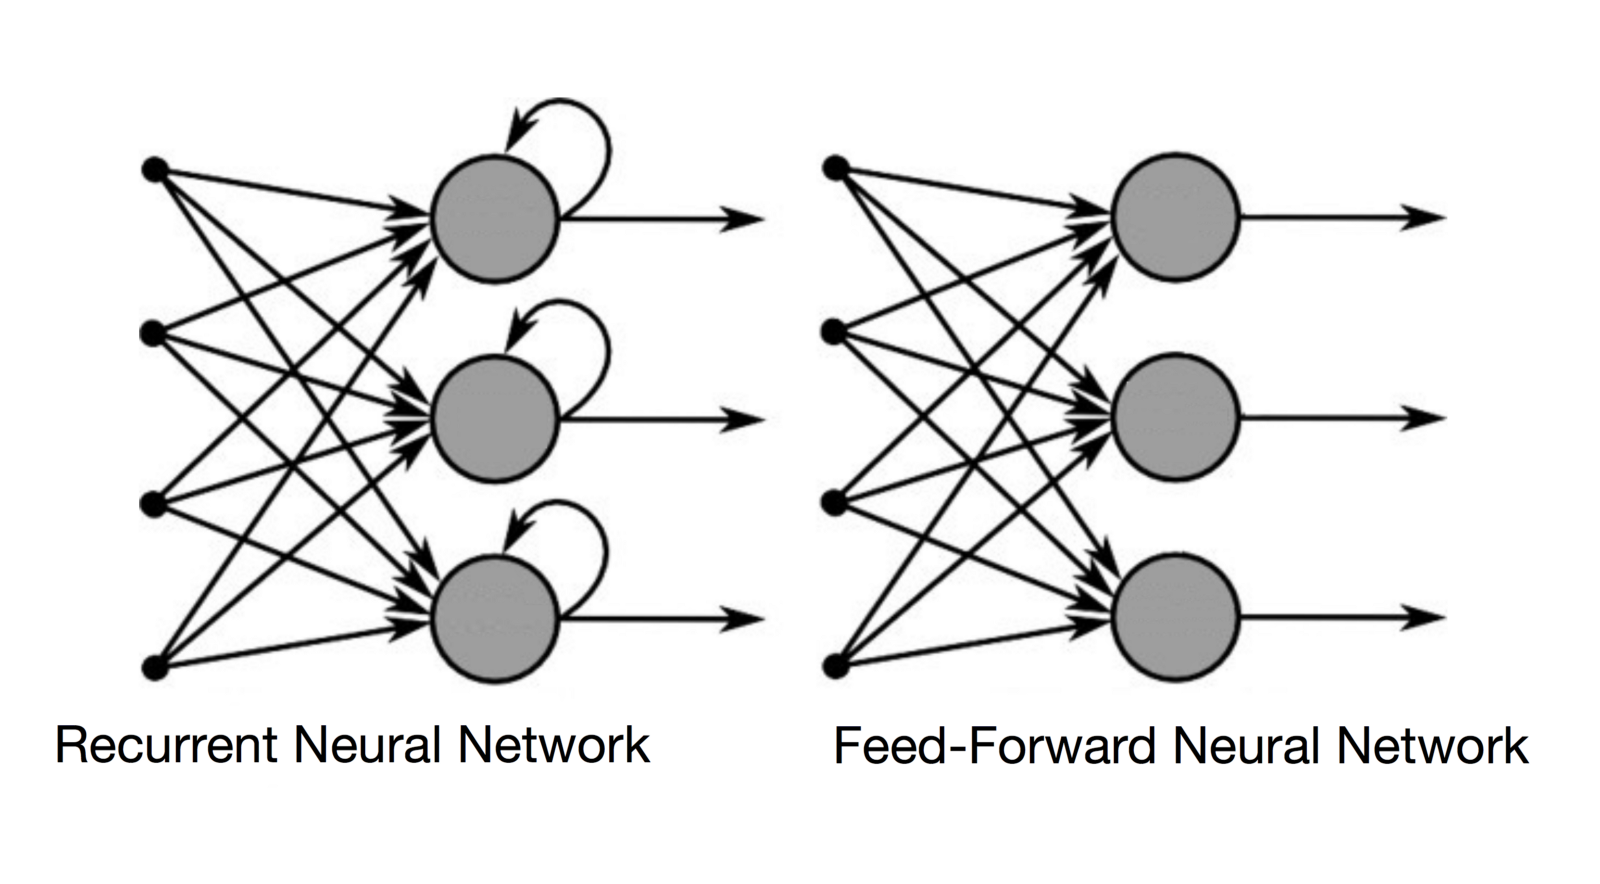

# Our Roadmap

To be able to create a program that trains on the historical BTC prices and predict tomorrow’s BTC price, we need to complete several tasks as follows:

1 — Obtaining, Cleaning, and Normalizing the Historical BTC Prices

2 — Building an RNN with LSTM

3 — Training the RNN and Saving The Trained Model

4 — Predicting Tomorrow’s BTC Price and “Deserialize” It

BONUS: Deserializing the X_Test Predictions and Creating a Plot.ly Chart

# Obtaining, Cleaning, and Normalizing the Historical BTC Prices
## Obtaining the BTC Data

As I mentioned above, we will use CoinRanking.com’s API for the BTC dataset and convert it into a Pandas dataframe with the following code:

In [ ]:
import requests,json,numpy as np,pandas as pd
#https://api.coinranking.com/v1/public/coin/:coin_id/history/:timeframe
#https://docs.coinranking.com/
def hist_price_dl(coin_id=1335,timeframe = "5y",currency = "USD"):
    '''It accepts coin_id, timeframe, and currency parameters to clean the historic coin data taken from COINRANKING.COM
    It returns a Pandas Series with daily mean values of the selected coin in which the date is set as the index'''
    r = requests.get("https://api.coinranking.com/v1/public/coin/"+str(coin_id)+"/history/"+timeframe+"?base="+currency)
    coin = json.loads(r.text)['data']['history'] #Reading in json and cleaning the irrelevant parts
    df = pd.DataFrame(coin)
    df['price'] = pd.to_numeric(df['price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms').dt.date
    return df.groupby('timestamp').mean()['price']

In [ ]:
def price_matrix_creator(data, seq_len=30):
    '''
    It converts the series into a nested list where every item of the list contains historic prices of 30 days
    '''
    price_matrix = []
    for index in range(len(data)-seq_len+1):
        price_matrix.append(data[index:index+seq_len])
    return price_matrix

def normalize_windows(window_data):
    '''
    It normalizes each value to reflect the percentage changes from starting point
    '''
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def train_test_split_(price_matrix, train_size=0.9, shuffle=False, return_row=True):
    '''
    It makes a custom train test split where the last part is kept as the training set.
    '''
    price_matrix = np.array(price_matrix)
    #print(price_matrix.shape)
    row = int(round(train_size * len(price_matrix)))
    train = price_matrix[:row, :]
    if shuffle==True:
        np.random.shuffle(train)
    X_train, y_train = train[:row,:-1], train[:row,-1]
    X_test, y_test = price_matrix[row:,:-1], price_matrix[row:,-1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    if return_row:
        return row, X_train, y_train, X_test, y_test
    else:
        X_train, y_train, X_test, y_test

In [ ]:
ser = hist_price_dl() # Not passing any argument since they are set by default
price_matrix = price_matrix_creator(ser) # Creating a matrix using the dataframe
price_matrix = normalize_windows(price_matrix) # Normalizing its values to fit to RNN
row, X_train, y_train, X_test, y_test = train_test_split_(price_matrix) # Applying train-test splitting, also returning the splitting-point

# Building an RNN with LSTM

After preparing our data, it is time for building the model that we will later train by using the cleaned&normalized data. We will start by importing our Keras components and setting some parameters with the following code:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import time
# LSTM Model parameters, I chose
batch_size = 2            # Batch size (you may try different values)
epochs = 15               # Epoch (you may try different values)
seq_len = 30              # 30 sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'linear'     # Linear activation
input_shape=(None,1)      # Input dimension
output_dim = 30           # Output dimension

Then, we will create our Sequential model with two LSTM and two Dense layers with the following code:

In [ ]:
model = Sequential()
model.add(LSTM(units=output_dim, return_sequences=True, input_shape=input_shape))
model.add(Dense(units=32,activation=activation))
model.add(LSTM(units=output_dim, return_sequences=False))
model.add(Dense(units=1,activation=activation))
model.compile(optimizer=optimizer,loss=loss)

## Training the RNN and Saving The Trained Model

Now it is time to train our model with the cleaned data. You can also measure the time spent during the training. Follow these codes:

In [ ]:
start_time = time.time()
model.fit(x=X_train,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)
end_time = time.time()
processing_time = end_time - start_time

Don’t forget to save it:

In [ ]:
model.save('coin_predictor.h5')

I am keen to save the model and load it later because it is quite satisfying to know that you can actually save a trained model and re-load to use it next time. This is basically the first step for web or mobile integrated machine learning applications.
Predicting Tomorrow’s BTC Price and “Deserialize” It

After we train the model, we need to obtain the current data for predictions, and since we normalize our data, predictions will also be normalized. Therefore, we need to de-normalize back to their original values. Firstly, we will obtain the data with a similar, partially different, manner with the following code:
Loading the last 30 days’ BTC Prices

We will only have the normalized data for prediction: No train-test split. We will also reshape the data manually to be able to use it in our saved model.

After cleaning and preparing our data, we will load the trained RNN model for prediction and predict tomorrow’s price.

In [ ]:
from keras.models import load_model
model = load_model('coin_predictor.h5')
preds = model.predict(X_test, batch_size=2)

However, our results will vary between -1 and 1, which will not make a lot of sense. Therefore, we need to de-normalize them back to their original values. We can achieve this with a custom function:

In [ ]:
def deserializer(preds, data, train_size=0.9, train_phase=False):
    '''
    Arguments:
    preds : Predictions to be converted back to their original values
    data : It takes the data into account because the normalization was made based on the full historic data
    train_size : Only applicable when used in train_phase
    train_phase : When a train-test split is made, this should be set to True so that a cut point (row) is calculated based on the train_size argument, otherwise cut point is set to 0
    
    Returns:
    A list of deserialized prediction values, original true values, and date values for plotting
    '''
    price_matrix = np.array(price_matrix_creator(ser))
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row=0
    date = ser.index[row+29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:,:-1]
    y_test = price_matrix[row:,-1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        pred = (preds[index]+1)* X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return [date+datetime.timedelta(days=1),y_test]

After defining the custom function, we will call these function and extract tomorrow’s BTC prices with the following code:

In [ ]:
final_pred = deserializer(preds, ser, train_size=0.9, train_phase=False)
final_pred[1][0]

With the code above, you can actually get the model’s prediction for tomorrow’s BTC prices.

# Deserializing the X_Test Predictions and Creating a Plot.ly **Chart**
You may also be interested in the overall result of the RNN model and prefer to see it as a chart. We can also achieve these by using our X_test data from the training part of the tutorial.

We will start by loading our model (consider this as an alternative to the single prediction case) and making the prediction on X_test data so that we can make predictions for a proper number of days for plotting with the following code:

In [ ]:
from keras.models import load_model
model = load_model('coin_predictor.h5')
preds = model.predict(X_test, batch_size=2)
plotlist = deserializer(preds, ser, train_phase=True)

Next, we will import Plotly and set the properties for a good plotting experience. We will achieve this with the following code:
Importing Plotly and Setting the Parameters

After setting all the properties, we can finally plot our predictions and observation values with the following code:
When you run this code, you will come up with the up-to-date version of the following plot:

In [ ]:
prices = pd.DataFrame({'Predictions':plotlist[1], 'Real Prices':plotlist[2]},index=plotlist[0])
iplot(prices.iplot(asFigure=True,
                   kind='scatter',
                   xTitle='Date',
                   yTitle='BTC Price',
                   title='BTC Price Predictions'))

# How Reliable Are These Results?

As you can see, it does not look bad at all. However, you need to know that even though the patterns match pretty closely, the results are still dangerously apart from each other if you inspect the results on a day-to-day basis. Therefore, the code must be further developed to get better results.
Congratulations

You have successfully created and trained an RNN model that can predict BTC prices, and you even saved the trained model for later use. You may use this trained model on a web or mobile application by switching to Object-Oriented Programming. Pat yourself on the back for successfully developing a model relevant to artificial intelligence, blockchain, and finance. I think it sounds pretty cool to touch these areas all at once with this simple project.